In [281]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import scipy.io as sio #allows for importing of .mat files 
import numpy

from torch.utils.data import DataLoader, sampler, TensorDataset 
import torch.nn.functional as F


In [646]:
# Import your data here
rootDir = r'C:\\Users\\izzyj\\Documents\\'

fn = 'firingrate.mat'


dtype = torch.float
conv_size = 3 # size of time history

# load the mat file
mat = sio.loadmat(rootDir+fn)
fire = torch.tensor(mat['firingrate'])
nsamp = fire.shape[0]
ntrain = int(numpy.round(nsamp*0.8))
ntest = nsamp-ntrain - 1
firetrain = fire[:,0:ntrain, :]
firetest = fire[:,ntrain+1:nsamp, :]


#collapse classification and create y matrix
X_train = torch.tensor(numpy.transpose(numpy.concatenate((firetrain[:,:,0], firetrain[:,:,1], firetrain[:,:,2], firetrain[:,:,3], firetrain[:,:,4], firetrain[:,:,5], firetrain[:,:,6], firetrain[:,:,7]), axis = 1))).to(dtype)
T0 = torch.full((1,ntrain),0)
T1 = torch.full((1,ntrain),1)
T2 = torch.full((1,ntrain),2)
T3 = torch.full((1,ntrain),3)
T4 = torch.full((1,ntrain),4)
T5 = torch.full((1,ntrain),5)
T6 = torch.full((1,ntrain),6)
T7 = torch.full((1,ntrain),7)
y_train = torch.cat((T0,T1, T2,T3,T4,T5,T6,T7), dim=1).to(dtype)
y_train = torch.squeeze(y_train).to(dtype)

X_test = torch.tensor(numpy.transpose(numpy.concatenate((firetest[:,:,0], firetest[:,:,1], firetest[:,:,2], firetest[:,:,3], firetest[:,:,4], firetest[:,:,5], firetest[:,:,6], firetest[:,:,7]), axis = 1))).to(dtype)
T0 = torch.full((1,ntest),0)
T1 = torch.full((1,ntest),1)
T2 = torch.full((1,ntest),2)
T3 = torch.full((1,ntest),3)
T4 = torch.full((1,ntest),4)
T5 = torch.full((1,ntest),5)
T6 = torch.full((1,ntest),6)
T7 = torch.full((1,ntest),7)
y_test = torch.cat((T0,T1, T2,T3,T4,T5,T6,T7), dim=1).to(dtype)
y_test = torch.squeeze(y_test).to(dtype)


# Initialize tensor with conv_size*nfeatures features
X_ctrain = torch.zeros((int(X_train.shape[0]), int(X_train.shape[1]*conv_size)), dtype=dtype)
X_ctest = torch.zeros((int(X_test.shape[0]), int(X_test.shape[1]*conv_size)), dtype=dtype)
X_ctrain[:,0:X_train.shape[1]] = X_train
X_ctest[:,0:X_test.shape[1]] = X_test


#Add the previous 3 time bins features as a feature in the current time bin
for k1 in range(conv_size-1):
    k = k1+1
    X_ctrain[k:, int(X_train.shape[1]*k):int(X_train.shape[1]*(k+1))] = X_train[0:-k, :]
    X_ctest[k:, int(X_test.shape[1]*k):int(X_test.shape[1]*(k+1))] = X_test[0:-k, :]

#print(X_ctrain.shape)
# Create Dataset and dataloader
test_ds= TensorDataset(X_ctest, y_test.T)
train_ds = TensorDataset(X_ctrain, y_train.T)

#If a batch in BatchNorm only has 1 sample it wont work, so dropping the last in case that happens
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, drop_last=True)
test_dl = DataLoader(test_ds, batch_size=len(test_ds), shuffle=False, drop_last=True)



In [713]:
class myNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size2, hidden_size3, hidden_size4, hidden_size5, num_states):
        super().__init__()
        # Define the different layers

        #  Input layer
        self.bn1 = nn.BatchNorm1d(input_size) # batch normalize inputs to fc1
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout(0.5)

        #  Hidden layer 1 for 1 hidden layer NN
#        self.bn2 = nn.BatchNorm1d(hidden_size)
#        self.fc2 = nn.Linear(hidden_size, hidden_size)
#        self.dropout2 = nn.Dropout(0.5)

        
        #  Hidden layer 1 for 5 hidden layer NN
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size2)
        self.dropout2 = nn.Dropout(0.5)
        
        #  Hidden layer 2
        self.bn3 = nn.BatchNorm1d(hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.dropout3 = nn.Dropout(0.5)
        
        #  Hidden layer 3
        self.bn4 = nn.BatchNorm1d(hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.dropout4 = nn.Dropout(0.5)
        
        #  Hidden layer 4
        self.bn5 = nn.BatchNorm1d(hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, hidden_size5)
        self.dropout5 = nn.Dropout(0.5)
        
        #  Hidden layer 5
        self.bn6 = nn.BatchNorm1d(hidden_size5)
        self.fc6 = nn.Linear(hidden_size5, hidden_size5)
        self.dropout6 = nn.Dropout(0.5)
    

        #  Output layer for 5 hidden layer NN
        self.bn7 = nn.BatchNorm1d(hidden_size5)
        self.fc7 = nn.Linear(hidden_size5, num_states)

        #  Output layer for 1 hidden layer NN
#        self.bn7 = nn.BatchNorm1d(hidden_size)
#        self.fc7 = nn.Linear(hidden_size, num_states)
        
        # Initialization
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        #nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')

    def forward(self, x):
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        
        x = self.bn2(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        
        x = self.bn3(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
       
        
        x = self.bn4(x)
        x = F.relu(self.fc4(x))
        x = self.dropout4(x)
        
        x = self.bn5(x)
        x = F.relu(self.fc5(x))
        x = self.dropout5(x)

        x = self.bn6(x)
        x = F.relu(self.fc6(x))
        x = self.dropout6(x)        
        
        x = self.bn7(x)
        x = self.fc7(x)
        
        scores = x
        #scores = F.log_softmax(x,dim=1)
        
        return scores


In [718]:
# Specify a model, loss function, and optimizer
weight_decay = 1e-5
learning_rate = 0.005

#### Your code here for creating the network
network = myNetwork(285, 256,200,150,100, 50, 8)

#Define the loss function
criterion = nn.CrossEntropyLoss()

#Define the optimizer
 
opt = torch.optim.SGD(network.parameters(), lr = learning_rate)
####? 



In [719]:
def myfit(epochs, nntofit, loss_fn, opt, train_dl, val_dl, print_every=1):
    train_loss = torch.zeros(epochs * len(train_dl) , dtype=torch.float) # train error for every iteration
    validation_loss = torch.zeros(epochs , dtype=torch.float) # validation is only once per epoch
    i = -1 # iteration number
    iters_sub, train_acc, val_acc = [], [] ,[]
    for epoch in range(epochs):
        #print(epoch)
        for x,y in train_dl: # batch of training points
            i += 1
            # Set model in train mode (for batch normalization and dropout)
            nntofit.train()
            
            # 1. Generate your predictions by running x through the network
            yh = nntofit(x)
            ####?
            
            #print(yh.shape)
            # 2. Find Loss by comparing predicted and actual using loss function
            loss = loss_fn(yh, y.type(torch.LongTensor))
            ####?
            #opt.zero_grad()
            # 3. Calculate gradients with respect to weights/biases 
            loss.backward()
            train_loss[i] = loss.item() #Keep track of loss on training data      
            # 4. Adjust your weights by taking a step forward on the optimizer
            opt.step()
            # 5. Reset the gradients to zero on the optimizer
            opt.zero_grad()
            ####?
   
            nntofit.eval()
            iters_sub.append(i)
            train_acc.append(get_accuracy(nntofit, train_ds))
            val_acc.append(get_accuracy(nntofit, test_ds))            
            
        #Validation accuracy
        for xval,yval in val_dl:
            with torch.no_grad(): # disable gradient calculation
                nntofit.eval() # set model to evaluation mode (matters for batch normalization and dropout)
                loss2 = loss_fn(nntofit(xval),yval.type(torch.LongTensor))
                validation_loss[epoch] = loss2.item()
    
    
    plt.title("Training Curve (lr={}, wd={})".format(learning_rate, weight_decay))
    plt.plot(iters_sub, train_acc, label="Train")
    plt.plot(iters_sub, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylim([0, 1])
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    return train_loss, validation_loss, nntofit

def get_accuracy(model, data):
    loader = torch.utils.data.DataLoader(data, batch_size=500)
    correct, total = 0, 0
    #print(loader)
    for xs, ts in loader:
        #xs = xs.view(-1, 784) # flatten the image
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(ts.view_as(pred)).sum().item()
        total += int(ts.shape[0])
        return correct / total


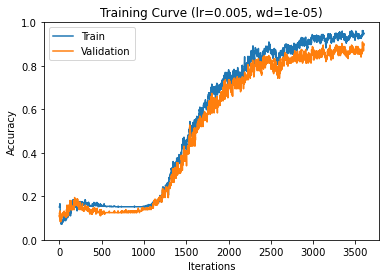

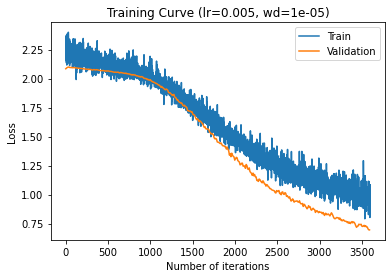

In [720]:
# Train the network
n_epochs = 400
train_loss, validation_loss, model = myfit(n_epochs, network, criterion, opt, train_dl, test_dl)

# Plot training and validation losses
plot_epochs = n_epochs

val_iters = numpy.arange(0,n_epochs)*len(train_dl)
train_iters = numpy.arange(0,len(train_dl)*n_epochs)
n_iter = len(train_dl) * n_epochs # number of batches per epoch * number of epochs 

plt.plot(train_iters[0:plot_epochs*len(train_dl)], train_loss[0:plot_epochs*len(train_dl)], label = "Train")
plt.title("Training Curve (lr={}, wd={})".format(learning_rate, weight_decay))

plt.plot(val_iters[0:plot_epochs], validation_loss[0:plot_epochs], label = "Validation")
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

In [717]:
yh = model(X_ctest)
zs = model(X_ctest)
pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
correct = pred.eq(y_test.view_as(pred)).sum().item()
total = int(y_test.shape[0])
print(correct/total)


0.7083333333333334


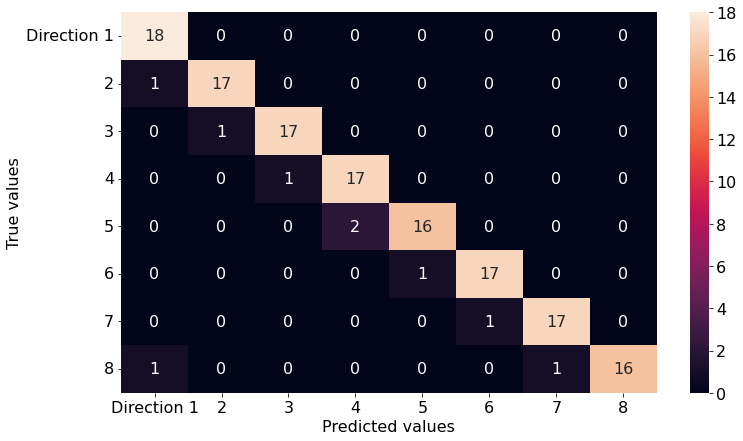

In [660]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
plt.rcParams.update({'font.size': 16})
y_pred = []
y_true = []
for x,y in test_dl:
    with torch.no_grad():
        yh = network(x)
        yh = (torch.max(torch.exp(yh),1)[1]).data.cpu().numpy()
        y_pred.extend(yh)
        labels = y.data.cpu().numpy()
        y_true.extend(labels)
        
classes = ('Direction 1', '2', '3', '4', '5','6', '7', '8')
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])

plt.figure(figsize = (12,7))

sn.heatmap(df_cm, annot=True)

plt.xlabel('Predicted values')
plt.ylabel('True values')

plt.rcParams.update({'font.size': 10})
